# Results analysis

#### dataset Loading and options 

In [1]:
from datasets import (
    Dataset,
    load_dataset,
    concatenate_datasets,
    get_dataset_config_names,
)
import pandas as pd
import seaborn as sb

all_configs = [
    config_name
    for config_name in get_dataset_config_names("CharlyR/vtikz-evaluation")
    if "benchmark" in config_name
]
print(all_configs)


all_datasets: list[Dataset] = []

for config in all_configs:
    conf_ds = load_dataset("CharlyR/vtikz-evaluation", config, split="tikz")
    config_name_column = ["".join(config.split("_benchmark"))] * len(conf_ds)
    all_datasets.append(conf_ds.add_column("config", config_name_column))


dataset = concatenate_datasets(all_datasets)

import os

result_path = os.path.join("results", "all_results")
not os.path.exists("results/all_results") and os.mkdir("results/" + "all_results")

/home/creux/miniconda3/envs/varbench/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['FAR_benchmark_llama3.370bversatile_pk_5_t_0.7', 'VIF_benchmark_llama3.370bversatile_t_0.0_search_gemini2.0flash_t_0.0_identification_gemini2.0flash_t_0.3', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_1_t_0.7', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_0.7', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_1.5', 'simpleLLM_benchmark_gpt4o20240806_pk_5_t_0.7', 'simpleLLM_benchmark_llama3.18binstant_pk_1_t_0.7', 'simpleLLM_benchmark_llama3.370bversatile_pk_1_t_0.7', 'simpleLLM_benchmark_llama3.370bversatile_pk_5_t_0.7', 'simpleLLM_benchmark_llama370b8192_pk_1_t_0.7', 'simpleLMM_benchmark_gpt4o20240806_pk_5_t_0.7']


False

## Variants Overall Validity

In [2]:
df  = dataset.to_pandas()[["config","id","parsing_score","compiling_score"]]

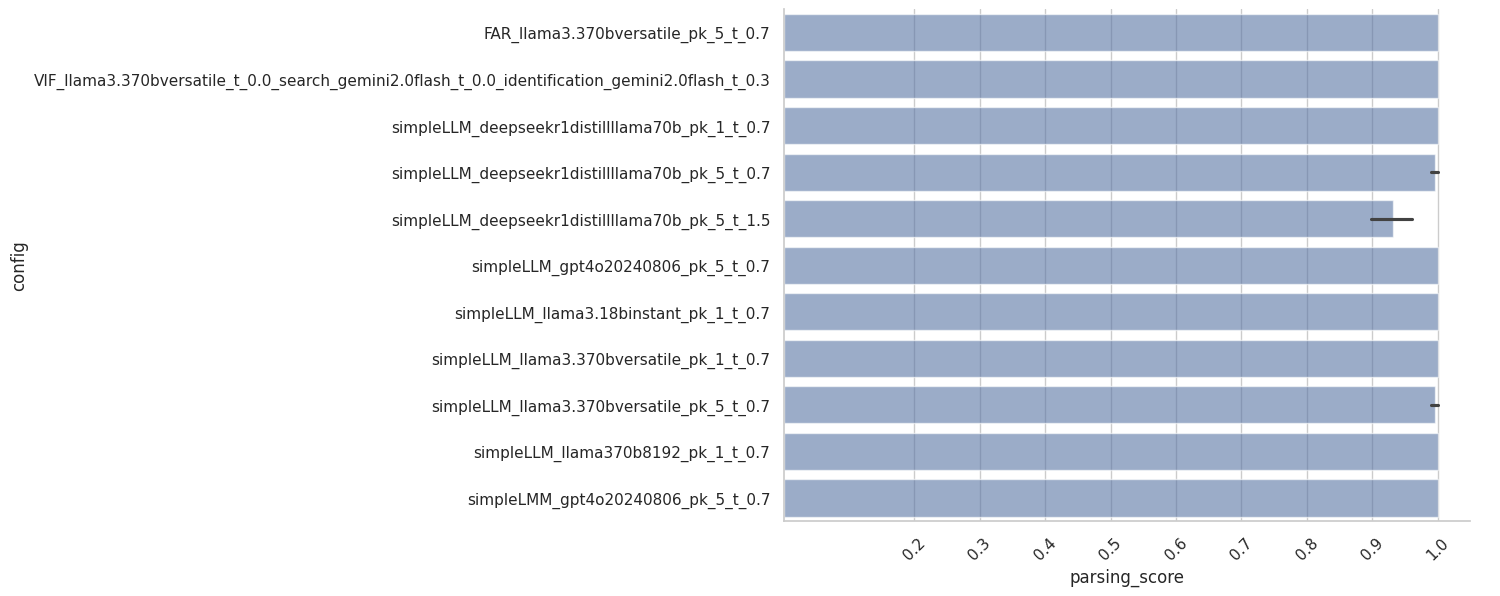

In [3]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
g = sns.catplot(
    data=df, kind="bar",
    x="parsing_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["parsing_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

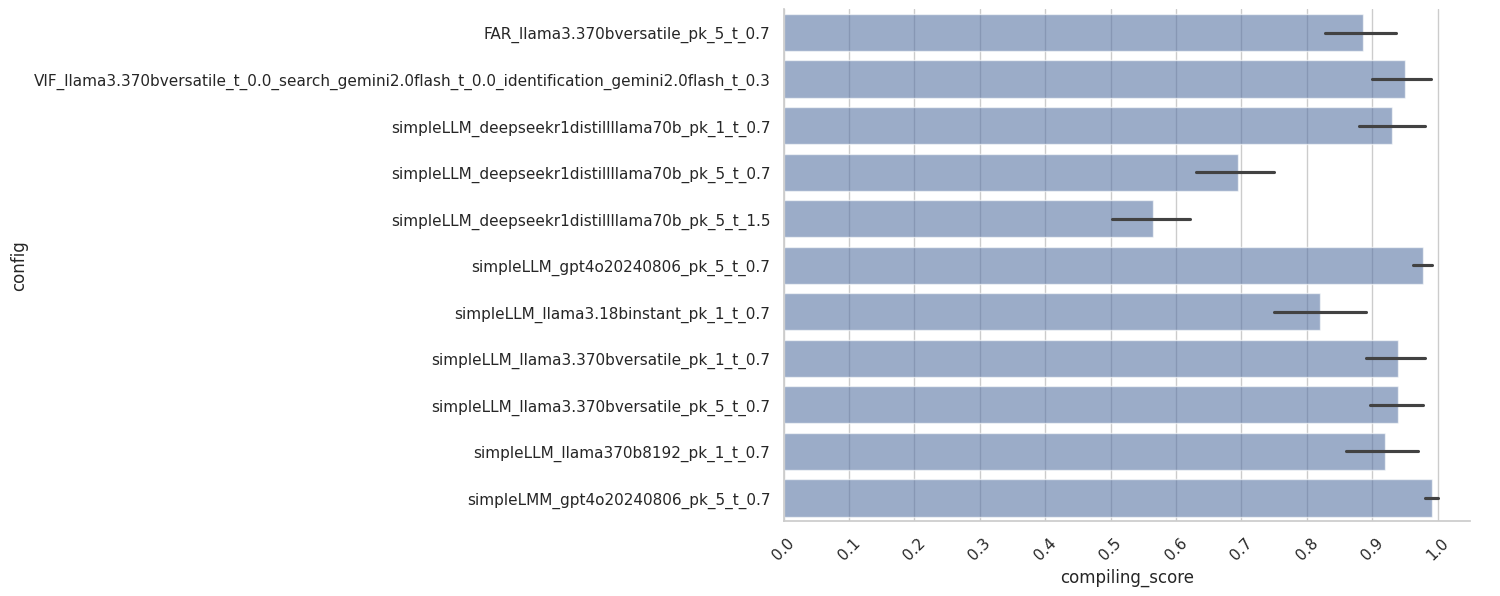

In [4]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="compiling_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["compiling_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

## Best prediction computation

---

In [5]:
import pandas as pd

computed_metrics_names = [
    metric_name
    for metric_name in dataset.column_names
    if metric_name.endswith("Metric")
]

most_important_metrics = ["TemplateMetric", "ImageEqualityMetric", "LineMetric", "CrystalBleuPatchMetric"]
metric_priority_order = most_important_metrics + (
    list(set(computed_metrics_names) - set(most_important_metrics))
)

print(
    computed_metrics_names
    + ["patch", "template_solution_code", "code_solution", "difficulty_ast"]
)

result_df: pd.DataFrame = dataset.to_pandas().explode(
    computed_metrics_names
    + ["patch", "template_solution_code", "code_solution", "difficulty_ast"]
)


['LineMetric', 'ImageEqualityMetric', 'TemplateMetric', 'CrystalBleuPatchMetric', 'patch', 'template_solution_code', 'code_solution', 'difficulty_ast']


In [6]:

#passk priotiry
print(computed_metrics_names + ["images_result", "predictions", "predictions_patches"])

result_df: pd.DataFrame = result_df.explode(
    computed_metrics_names + ["images_result", "predictions", "predictions_patches"]
)
df_sorted = result_df.sort_values(by=metric_priority_order, ascending=False)
df_sorted

# Get the highest row per group based on sorting order
result = df_sorted.groupby(["id", "config"]).first().reset_index()


result_df = result[computed_metrics_names + ["id", "config","difficulty"]].astype({m_name:'float' for m_name in computed_metrics_names})
result_df

['LineMetric', 'ImageEqualityMetric', 'TemplateMetric', 'CrystalBleuPatchMetric', 'images_result', 'predictions', 'predictions_patches']


,LineMetric,ImageEqualityMetric,TemplateMetric,CrystalBleuPatchMetric,id,config,difficulty
0,0.0,0.0,0.0,5.287866,beam_coord_change,FAR_llama3.370bversatile_pk_5_t_0.7,easy
1,0.0,NaN,0.0,19.106014,beam_coord_change,VIF_llama3.370bversatile_t_0.0_search_gemini2....,easy
2,0.0,0.0,0.0,10.181436,beam_coord_change,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,easy
3,100.0,0.0,0.0,83.939598,beam_coord_change,simpleLLM_deepseekr1distillllama70b_pk_5_t_0.7,easy
4,100.0,0.0,0.0,83.939598,beam_coord_change,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,easy
...,...,...,...,...,...,...,...
1095,0.0,NaN,0.0,1.136528,zoomedtriangle_centered,simpleLLM_llama3.18binstant_pk_1_t_0.7,easy
1096,100.0,100.0,0.0,64.603882,zoomedtriangle_centered,simpleLLM_llama3.370bversatile_pk_1_t_0.7,easy
1097,100.0,100.0,100.0,100.000000,zoomedtriangle_centered,simpleLLM_llama3.370bversatile_pk_5_t_0.7,easy
1098,100.0,100.0,100.0,100.000000,zoomedtriangle_centered,simpleLLM_llama370b8192_pk_1_t_0.7,easy


## Pre-Filtering

In [7]:
# ordering by text metrics IGNORED
""" text_metrics = [
    metric_name
    for metric_name in computed_metrics_names
    if any((substring in metric_name) for substring in ["TER", "Line", "Bleu", "Chrf","Patch"])
]
other_metrics = list(set(computed_metrics_names) - set(text_metrics))
ordered_metrics = [metric for metric in (text_metrics + other_metrics)]
print(text_metrics + other_metrics) """
#Ordering by priority metrics
filtered_df = result_df[metric_priority_order+ ["id", "config","difficulty"]]
#filtered_df["LineMetric"] = filtered_df["LineMetric"].fillna(0)
#filtered_df["PatchMetric"] = filtered_df["PatchMetric"].fillna(0)

## CompileMetric

In [8]:
def compute_pass(row):
    row["pass"] = (not row.isnull().any())*100
    return row
pass_dataset = filtered_df[computed_metrics_names+["difficulty","id","config"]].apply(compute_pass,axis=1)


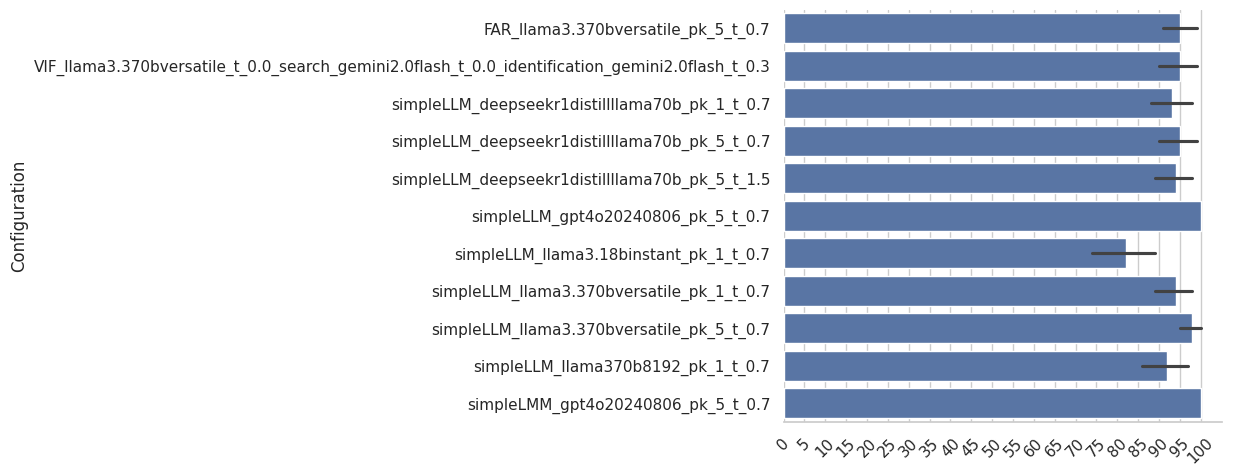

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=pass_dataset, kind="bar", x="pass",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(0, 100.01, step=5))  # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Configuration")
g.legend.set_title("")
plt.savefig(os.path.join(result_path,"pass_rate.png"), dpi=300, bbox_inches="tight")

plt.show()



## SucessCustomization Metric

/tmp/ipykernel_16912/2499699430.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["SuccessCustomizationMetric"] = np.where(


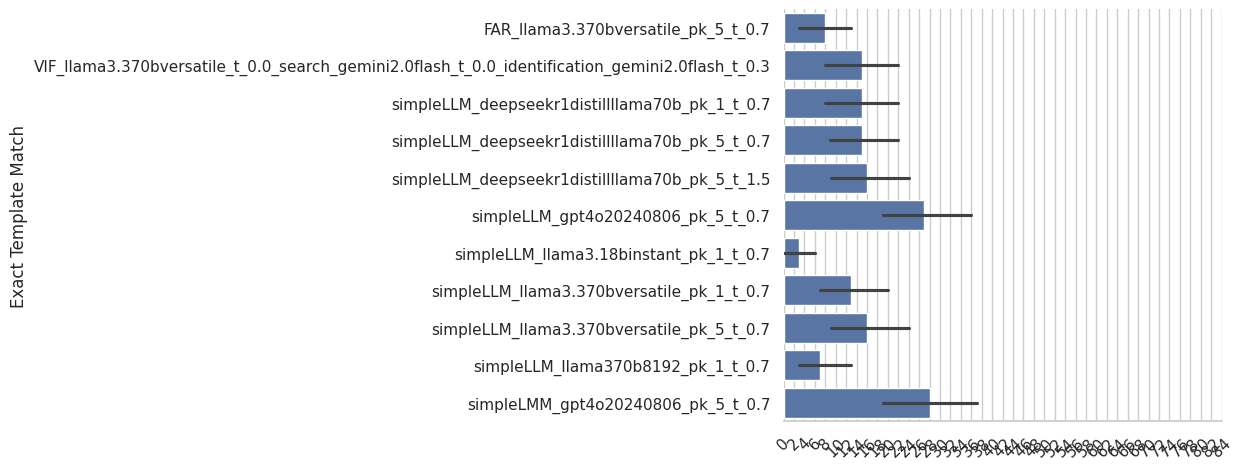

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

filtered_df["SuccessCustomizationMetric"] = np.where(
    (filtered_df["TemplateMetric"] == 100) | (filtered_df["ImageEqualityMetric"] == 100),
    100,
    0
)

g = sns.catplot(
    data=filtered_df, kind="bar", x="SuccessCustomizationMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["SuccessCustomizationMetric"].mean()+filtered_df["SuccessCustomizationMetric"].std()*2, 2)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Exact Template Match")
g.legend.set_title("")
plt.savefig(os.path.join(result_path,"same_patch_measures.png"), dpi=300, bbox_inches="tight")

plt.show()


## LineMetric

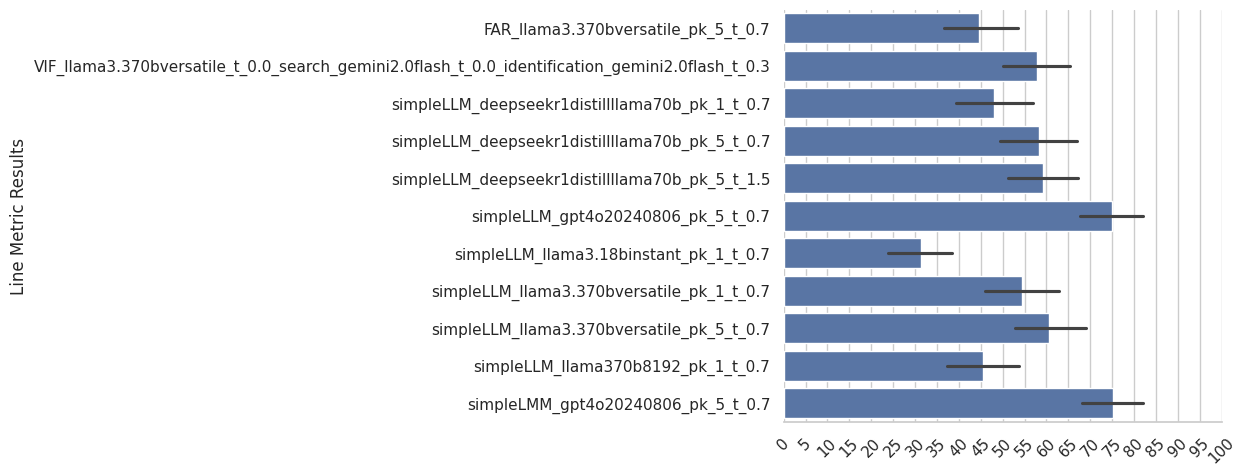

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="LineMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["LineMetric"].max()+1, 5)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Line Metric Results")
g.legend.set_title("")

plt.savefig(os.path.join(result_path,"irght_lines_measures.png"), dpi=300, bbox_inches="tight")
plt.show()


## LocationMetric

/tmp/ipykernel_16912/3098151122.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["LocationMetric"] = np.where(filtered_df["LineMetric"]>=100,100,0)


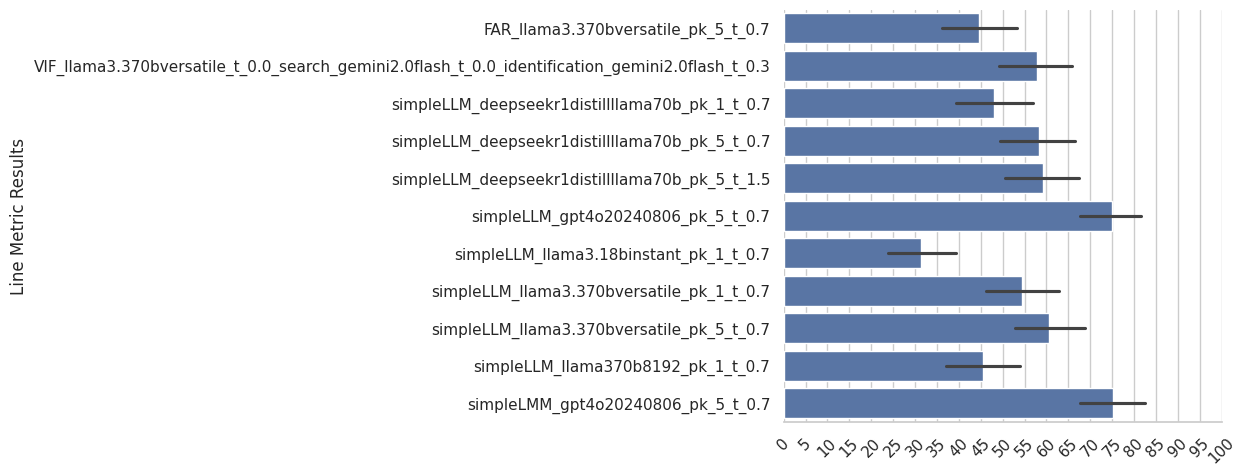

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
filtered_df["LocationMetric"] = np.where(filtered_df["LineMetric"]>=100,100,0)

g = sns.catplot(
    data=filtered_df, kind="bar", x="LineMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["LineMetric"].max()+1, 5)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Line Metric Results")
g.legend.set_title("")

plt.savefig(os.path.join(result_path,"irght_lines_measures.png"), dpi=300, bbox_inches="tight")
plt.show()


## Similarity metric

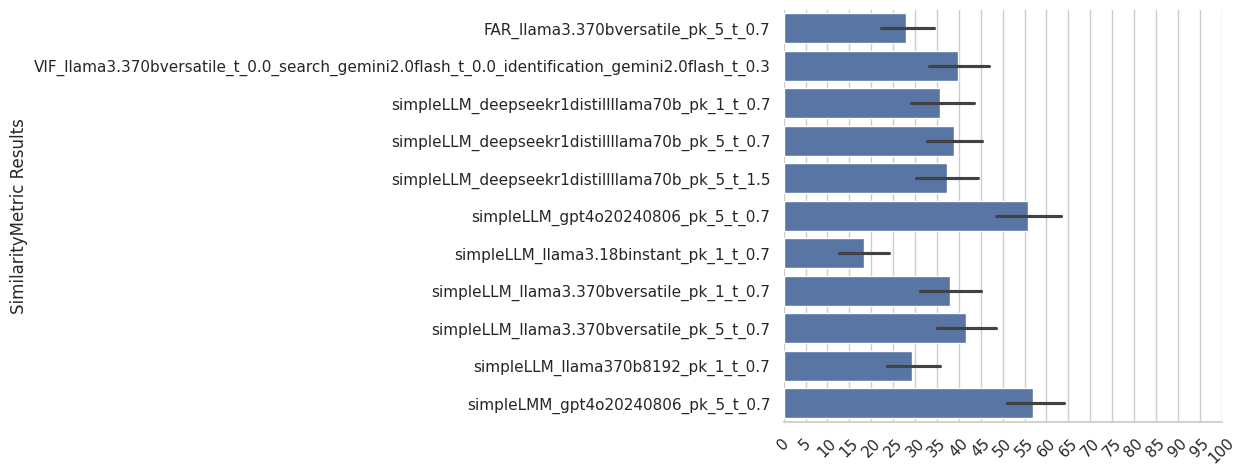

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="CrystalBleuPatchMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["CrystalBleuPatchMetric"].max()+1, 5)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "SimilarityMetric Results")
g.legend.set_title("")

plt.savefig(os.path.join(result_path,"similarityMetric_measures.png"), dpi=300, bbox_inches="tight")
plt.show()

## variant classification

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd

def plot_nested_circles_subplot(classed_dataset: pd.DataFrame):
    """
    Generates subplots of nested circle diagrams for each configuration in the dataset.
    Uses a blue gradient color scheme and places values slightly below the top of each circle.
    Only one shared legend is created for the entire plot.
    """
    sns.set()
    
    configs = classed_dataset["model"].unique()
    num_configs = len(configs)
    
    # Calculate the number of rows needed, with a maximum of 3 subplots per row
    ncols = 3
    nrows = (num_configs + ncols - 1) // ncols  # This ensures enough rows
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten()  # Flatten to easily iterate over

    legend_handles = []  # Collect all legend handles here
    
    for i, config in enumerate(configs):
        ax = axes[i]
        ax.set_aspect('equal')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

        cols = classed_dataset.columns.to_list()
        cols.remove("model")
        classes = classed_dataset[classed_dataset["model"] == config][cols].iloc[0].to_dict()
        
        max_r = max(classes.values())
        ax.set_xlim(-max_r - 1, max_r + 1)
        ax.set_ylim(-1, max_r * 2 + 1)

        n = len(classes)
        cmap = LinearSegmentedColormap.from_list('blue_gradient', ['#ADD8E6', '#00008B'], N=n)
        colors = [cmap(i) for i in np.linspace(0, 1, n)]

        sorted_classes = sorted(classes.items(), key=lambda x: x[1], reverse=True)

        for (label, r), color in zip(sorted_classes, colors):
            circle = plt.Circle((0, r), r, fill=True, facecolor=color, alpha=0.6,
                                edgecolor='black', linewidth=2)
            ax.add_patch(circle)

            # Collect the legend handles (only once for each unique color)
            if i == 0:  # Only create the legend once, for the first plot
                legend_handles.append(mpatches.Patch(color=color, label=f"{label}"))

            # Adjust text position
            ax.annotate(str(r),(0,r*2),(0,-1),ha='center', va='bottom', fontsize=18,textcoords='offset points')

        ax.set_title(f"{config}", y=1.05,fontsize=25)

    # Hide unused subplots
    for j in range(num_configs, len(axes)):
        axes[j].axis('off')

    # Create one shared legend for the entire plot
    fig.legend(handles=legend_handles, loc='lower right', bbox_to_anchor=(1, 0), frameon=True,fontsize="30")

    plt.tight_layout()
    plt.savefig(os.path.join(result_path, "concentric_variant_classif.png"), dpi=300, bbox_inches="tight")
    plt.show()


In [27]:
model_name_map = {
    "llama3.18binstant": "Llama-3.1-8B",
    "mixtral8x7b32768": "Mixtral-8x7B",
    "llama370b8192": "Llama-3-70B",
    "deepseekr1distillllama70b": "DeepSeek-R1-Distill-Llama-70B",
    "llama3.370bversatile": "Llama-3.3-70B",
    "gpt4o20240806": "GPT-4o-2024-08-06",
    "gemini2.0flash": "gemini-2.0-flash",
    "metallamallama4scout17b16einstruct":"Llama-4-Scout-17B-16E"
}

name_map = {"LLM": "Text", "LMM": "Text+Image", "VIF": "T","FAR":"FAR"}

def get_model_name(row):
    parts = row["config"].split("_")
    prefix = parts[0]
    model = model_name_map[parts[1]]
    name = name_map[prefix.removeprefix("simple")]

    if prefix == "VIF":
        suffix = (
            f" Temp. {parts[3]} "
            f"Search {'_'.join(parts[5:8])} "
            f"Identification {'_'.join(parts[9:12])}"
        )
    else:
        suffix = f" N={parts[3]} Temp. {parts[5]}"

    return f"{model}\n{name}{suffix}"


def compute_class(row):
    row["total"] = 1
    row["Compile"] = not row.isnull().any()
    row["Location"] = row["LocationMetric"] == 100
    row["SuccessCustomization"] = row["SuccessCustomizationMetric"] == 100
    row["model"] = get_model_name(row)
    return row


computed_metrics_names = [
    metric_name for metric_name in filtered_df.columns if metric_name.endswith("Metric")
]
classed_dataset = filtered_df[
    computed_metrics_names + ["difficulty", "id", "config"]
].apply(compute_class, axis=1)[
    [
        "difficulty",
        "id",
        "model",
        "total",
        "Compile",
        "Location",
        "SuccessCustomization",
    ]
]
classed_dataset = (
    classed_dataset.groupby("model")
    .sum()
    .reset_index()
    .sort_values("SuccessCustomization")
)

In [28]:
classed_dataset = classed_dataset[
    (~classed_dataset["model"].str.contains("Identification")) &
    (~classed_dataset["model"].str.contains("FAR")) &
    (~classed_dataset["model"].str.contains("Scout"))
].drop(["difficulty","id"],axis=1)

In [17]:
#plot_nested_circles_subplot(classed_dataset[["model","total", "Compile", "Location", "SuccessCustomization"]])


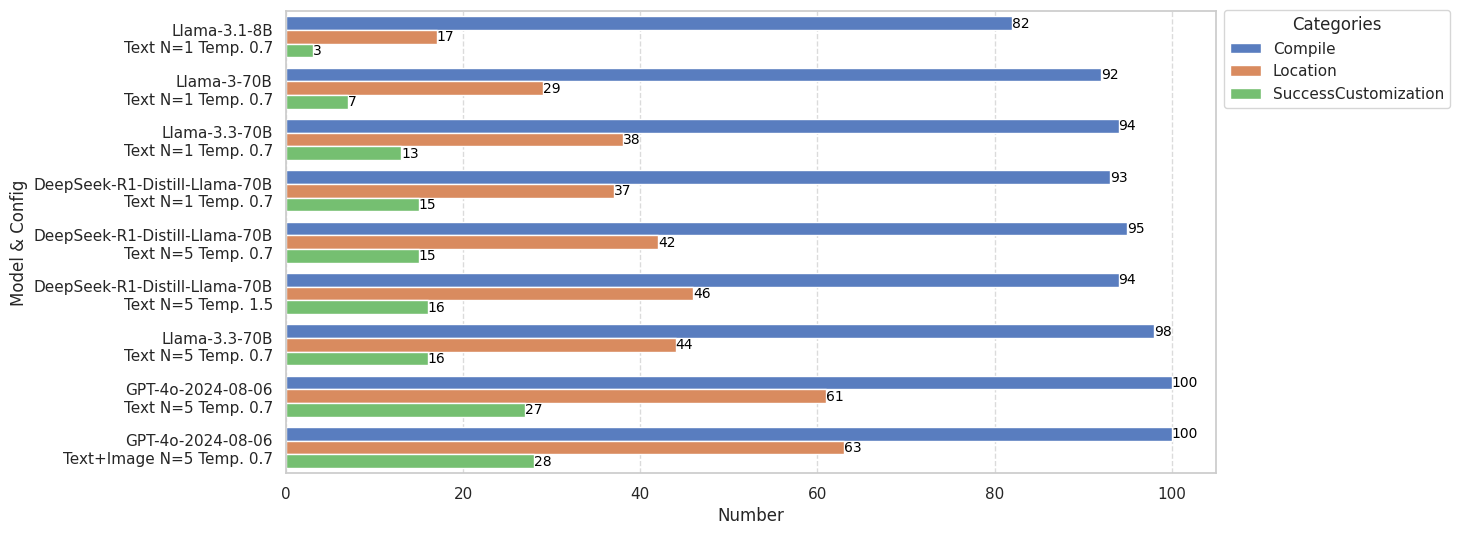

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

classed_dataset[["model","Compile", "Location", "SuccessCustomization"]]
# Plot settings
plt.figure(figsize=(12, 6))
df_melted = classed_dataset.melt(id_vars=["model"], value_vars=["Compile", "Location", "SuccessCustomization"], 
                    var_name="Metric", value_name="Score")

ax = sns.barplot(x="Score", y="model", hue="Metric", data=df_melted, palette="muted")
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10, color='black')
plt.xlabel("Number")
plt.ylabel("Model & Config")
plt.legend(title="Categories",loc="upper right",bbox_to_anchor=(1.26,1.02))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("results/all_results/var_classif.png",bbox_inches='tight')
plt.show()


In [19]:
classed_dataset.to_json("leaderboard.json")

## All metrics

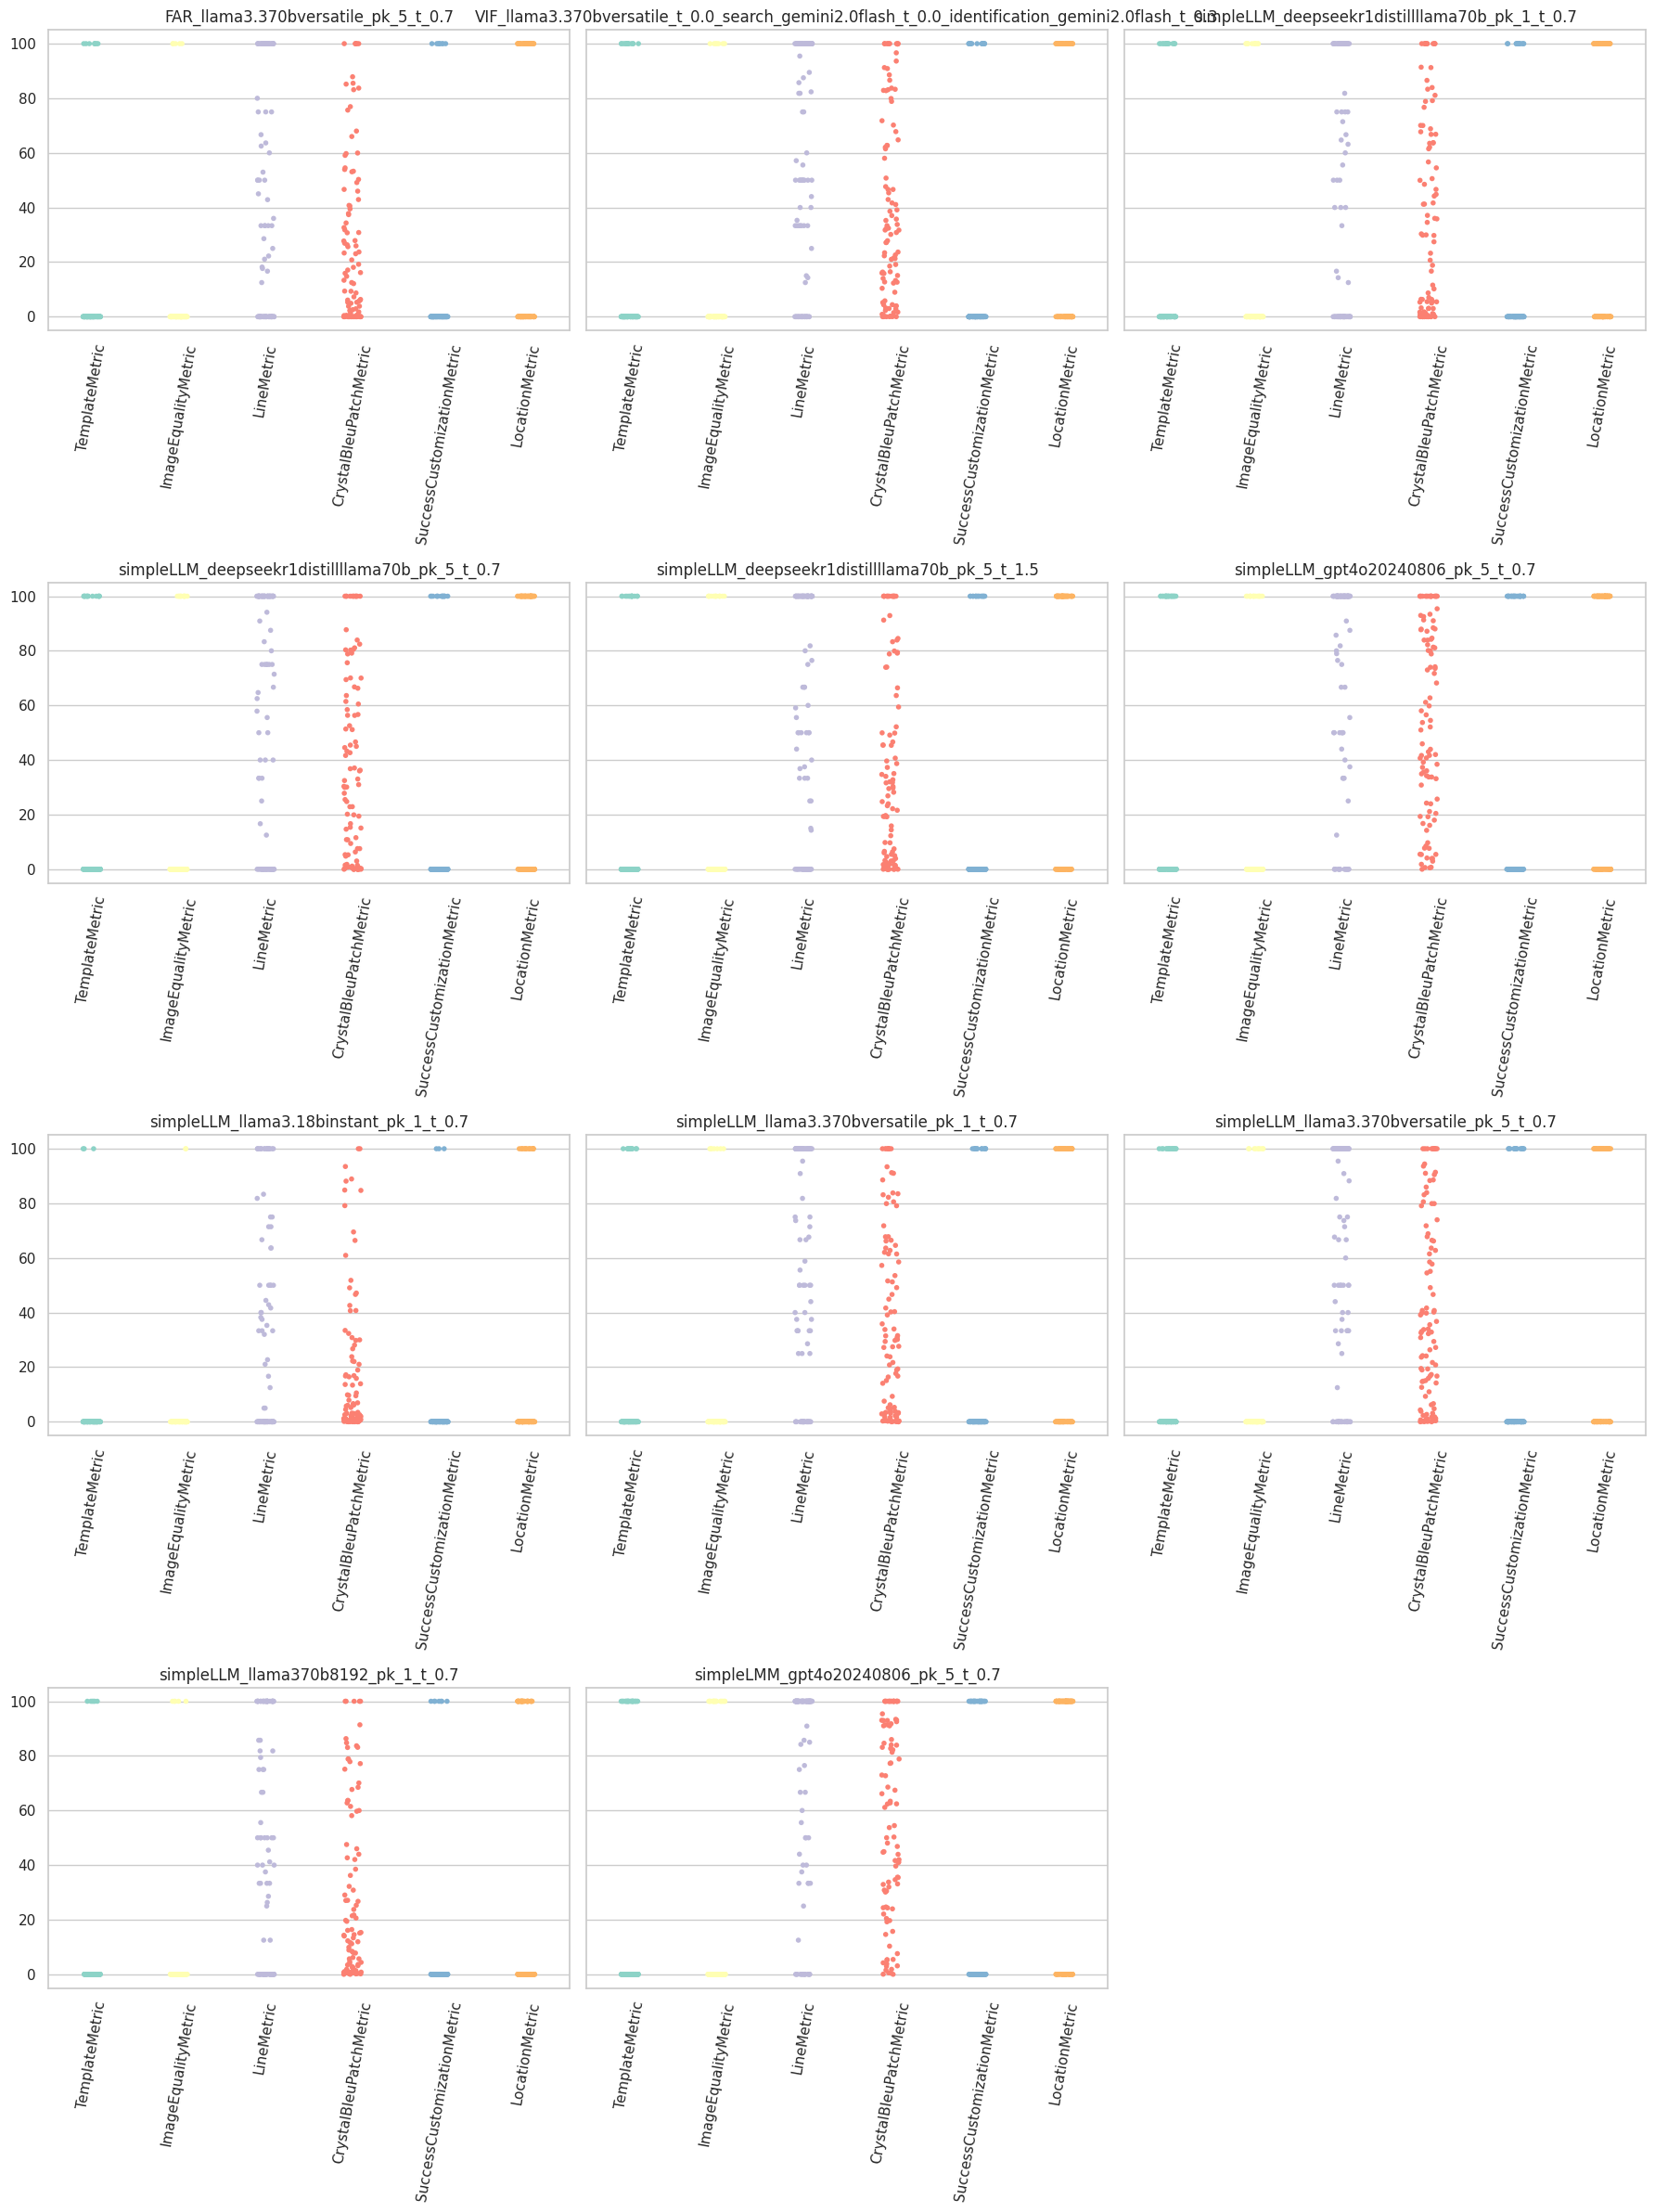

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_theme(style="whitegrid")

# Get unique configuration values
configs = filtered_df["config"].unique().tolist()

# Determine grid size
cols = 3
rows = (len(configs) // cols) + (len(configs) % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows), sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, config_name in enumerate(configs):
    sns.stripplot(
        data=filtered_df[filtered_df['config'] == config_name], 
        ax=axes[i], 
        palette="Set3",
        size=4,
        jitter=True
    )
    axes[i].set_title(f'{config_name}')
    axes[i].tick_params(axis='x', rotation=80)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(result_path, "strip_by_config.png"), dpi=300, bbox_inches="tight")
#plt.show()


In [21]:
filtered_df["config"] = pd.Categorical(
    filtered_df["config"], categories=configs, ordered=True
)


def get_compiling_score(row):
    row["Compile"] = (not row.isnull().any()) * 100
    return row


filtered_valid = filtered_df.apply(get_compiling_score, axis=1)

averages = (
    filtered_valid.drop(["difficulty", "id"], axis=1)
    .groupby("config", observed=True)
    .mean()
    .reset_index()
)
#filtering unwanted model configs for now
averages = averages[
    (~averages["config"].str.contains("VIF")) &
    (~averages["config"].str.contains("FAR")) &
     (~averages["config"].str.contains("scout"))
]


def apply_title_reduction(row):
    row["model"] = (
        model_name_map[row["config"].split("_")[1]]
    )
    row["Modality"] = name_map[row["config"].split("_")[0].removeprefix("simple")]
    row["N"] = row["config"].split("_")[3]
    row["temp."] = row["config"].split("_")[5]

    return row


averages = averages.apply(apply_title_reduction, axis=1)
averages = averages.drop("config", axis=1)
for col in averages.columns:
    averages = averages.rename(columns={col: col.removesuffix("Metric")})

averages = averages[
    ["model","Modality", "N", "temp."]
    + list(set(averages.columns.to_list()) - set(["model","Modality", "N", "temp."]))
]
averages = averages.sort_values(by="SuccessCustomization")



df_base = averages[["model","Modality", "N", "temp."]]


metrics = [(["CrystalBleuPatch", "Line"], "avg_by_config.tex", True)]

# Generate LaTeX files with resize for patch-based metrics
for cols, filename, apply_resize in metrics:
    df = df_base.join(averages[cols])
    path = os.path.join(result_path, filename)
    df.to_latex(path, float_format="%.1f", index=False)

    if apply_resize:  # Ensure resizebox is added correctly
        with open(path, "r") as f:
            content = f.read()
        with open(path, "w") as f:
            f.write(f"\\resizebox{{\\columnwidth}}{{!}}{{\n{content}\n}}")

/tmp/ipykernel_16912/2057379397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["config"] = pd.Categorical(


In [22]:
filtered_df['config'] = pd.Categorical(filtered_df['config'], categories=configs, ordered=True)
averages = filtered_df.drop(["difficulty","id"],axis=1).groupby('config',observed=True).median()
averages.to_csv(os.path.join(result_path,"med_by_config.csv"))

averages

/tmp/ipykernel_16912/3635423988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['config'] = pd.Categorical(filtered_df['config'], categories=configs, ordered=True)


,TemplateMetric,ImageEqualityMetric,LineMetric,CrystalBleuPatchMetric,SuccessCustomizationMetric,LocationMetric
config,,,,,,
FAR_llama3.370bversatile_pk_5_t_0.7,0.0,0.0,33.333332,16.621912,0.0,0.0
VIF_llama3.370bversatile_t_0.0_search_gemini2.0flash_t_0.0_identification_gemini2.0flash_t_0.3,0.0,0.0,56.349207,31.721792,0.0,0.0
simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,0.0,0.0,50.000000,28.594435,0.0,0.0
simpleLLM_deepseekr1distillllama70b_pk_5_t_0.7,0.0,0.0,75.000000,31.732911,0.0,0.0
simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,0.0,0.0,70.833332,28.862318,0.0,0.0
simpleLLM_gpt4o20240806_pk_5_t_0.7,0.0,0.0,100.000000,55.519619,0.0,100.0
simpleLLM_llama3.18binstant_pk_1_t_0.7,0.0,0.0,0.000000,4.863325,0.0,0.0
simpleLLM_llama3.370bversatile_pk_1_t_0.7,0.0,0.0,52.777779,29.966808,0.0,0.0
simpleLLM_llama3.370bversatile_pk_5_t_0.7,0.0,0.0,74.342106,33.415947,0.0,0.0


## DEBUG

In [23]:
debugdf = result.astype({m_name:'float' for m_name in ["TemplateMetric","ImageEqualityMetric","LineMetric"]})
debugdf["SuccessCustomizationMetric"] = np.where(
    (debugdf["TemplateMetric"] == 100) | (debugdf["ImageEqualityMetric"] == 100),
    100,
    0
)
debugdf["LocationMetric"] = np.where(debugdf["LineMetric"]>=100,100,0)

debugdf = debugdf[((debugdf["TemplateMetric"] == 100)) & (debugdf["LocationMetric"] < 100)]
print(debugdf["original_predictions"].iloc[0][0])


<think>
Alright, I need to figure out how to make the cat's mustache much longer in the given LaTeX code. Let me look at the code step by step.

First, I see that the cat is defined using a TikZ picture with a set of ellipses and paths. The mustache is probably one of these ellipses, perhaps the ones towards the top of the cat's face.

Looking through the code, I spot two sets of fill commands that might be the mustache. One is towards the middle of the code:

\fill [Grey100]
    (-1/2,-2) ellipse [x radius=1/3, y radius=1/4]
    ( 1/2,-2) ellipse [x radius=1/3, y radius=1/4];

But wait, that's near the bottom, so maybe those are other details. Moving further down, I see another part that seems more likely to be the mustache:

\foreach \i in {-1,1}
  \foreach \j in {-1,0,1}
    \fill [Grey100, shift={(0,11/8)}, xscale=\i, rotate=\j*15,
      shift=(0:1/2)]
      ellipse [x radius=1/3, y radius=1/64];

Hmm, that's near the top of the cat's face, so this might be the mustache. The part w

In [24]:
debugdf

,id,config,difficulty_ast,code,commented_code,instruction,result_description,difficulty,modification_type,type,...,images_result,parsing_score,compiling_score,predictions_patches,LineMetric,ImageEqualityMetric,TemplateMetric,CrystalBleuPatchMetric,SuccessCustomizationMetric,LocationMetric
136,cat_longer_mustache,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,2.0,"\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",Make the mustache of the cat much longer,"A cat, with vey long mustaches",easy,update,animal,...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1.0,0.4,"@@ -50 +50 @@\n\n-ellipse [x radius=1/3, y rad...",50.000000,0.0,100.0,34.717857,100,0
979,squid_bigger_eyes,FAR_llama3.370bversatile_pk_5_t_0.7,3.0,"\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",Make the eyes of the squid bigger,A squid with big roud eyes,medium,update,animal,...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1.0,1.0,"@@ -37,2 +37,2 @@\n\n-\fill [Grey50] (64, 16) ...",66.666664,0.0,100.0,49.131561,100,0
980,squid_bigger_eyes,VIF_llama3.370bversatile_t_0.0_search_gemini2....,3.0,"\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",Make the eyes of the squid bigger,A squid with big roud eyes,medium,update,animal,...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1.0,1.0,"@@ -37 +37 @@\n\n-\fill [Grey50] (64, 16) circ...",33.333332,0.0,100.0,12.649867,100,0
981,squid_bigger_eyes,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,3.0,"\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",Make the eyes of the squid bigger,A squid with big roud eyes,medium,update,animal,...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1.0,1.0,"@@ -37,2 +37,2 @@\n\n-\fill [Grey50] (64, 16) ...",66.666664,0.0,100.0,48.488739,100,0
983,squid_bigger_eyes,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,3.0,"\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",Make the eyes of the squid bigger,A squid with big roud eyes,medium,update,animal,...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1.0,1.0,"@@ -37,2 +37,2 @@\n\n-\fill [Grey50] (64, 16) ...",66.666664,0.0,100.0,49.131561,100,0
986,squid_bigger_eyes,simpleLLM_llama3.370bversatile_pk_1_t_0.7,3.0,"\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",Make the eyes of the squid bigger,A squid with big roud eyes,medium,update,animal,...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1.0,1.0,"@@ -37,2 +37,2 @@\n\n-\fill [Grey50] (64, 16) ...",66.666664,0.0,100.0,49.131561,100,0
987,squid_bigger_eyes,simpleLLM_llama3.370bversatile_pk_5_t_0.7,3.0,"\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",Make the eyes of the squid bigger,A squid with big roud eyes,medium,update,animal,...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1.0,1.0,"@@ -37,2 +37,2 @@\n\n-\fill [Grey50] (64, 16) ...",66.666664,0.0,100.0,49.131561,100,0


In [25]:
print(debug_df["original_predictions"].iloc[0])

NameError: name 'debug_df' is not defined